In [1]:
# Cell 1 - system

import sys
sys.path.append('src')

from __future__ import annotations
import torch

from typing import Callable

import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint
import torchaudio

import librosa

import os
import re
from importlib.resources import files
from pathlib import Path

import numpy as np
import soundfile as sf
import tomli
from cached_path import cached_path

import cyrtranslit


from f5_tts.infer.utils_infer import (
    infer_single_process,
    load_model,
    load_vocoder,
    preprocess_ref_audio_text,
    preprocess_ref_audio_text_segment,
    remove_silence_for_generated_wav,
)

from f5_tts.model.utils import (
    default,
    exists,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

from f5_tts.model import DiT, UNetT

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Image, Audio

# Direct variable assignments instead of command line arguments
model = "F5-TTS"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_40000.pt"
ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_last.pt"

# Default configurations
config_path = os.path.join(files("f5_tts").joinpath("infer/examples/basic"), "basic.toml")
config = tomli.load(open(config_path, "rb"))

# Additional settings with default values
vocab_file = ""
output_dir = config["output_dir"]
remove_silence = config.get("remove_silence", False)
speed = 1.0
vocoder_name = "vocos"
load_vocoder_from_local = False
wave_path = Path(output_dir) / "infer_cli_out.wav"

# Vocoder settings
if vocoder_name == "vocos":
    vocoder_local_path = "../checkpoints/vocos-mel-24khz"
elif vocoder_name == "bigvgan":
    vocoder_local_path = "../checkpoints/bigvgan_v2_24khz_100band_256x"
mel_spec_type = vocoder_name


vocoder = load_vocoder(vocoder_name=mel_spec_type, is_local=load_vocoder_from_local, local_path=vocoder_local_path)

# Model configuration
if model == "F5-TTS":
    model_cls = DiT
    model_cfg = dict(dim=1024, depth=22, heads=16, ff_mult=2, text_dim=512, conv_layers=4)
    # if not ckpt_file:
    #     if vocoder_name == "vocos":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base"
    #         ckpt_step = 1200000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.safetensors"))
    #     elif vocoder_name == "bigvgan":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base_bigvgan"
    #         ckpt_step = 1250000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.pt"))


ema_model = load_model(model_cls, model_cfg, ckpt_file, mel_spec_type=vocoder_name, vocab_file=vocab_file)

ckpt_file_fine = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"
ema_model_fine = load_model(model_cls, model_cfg, ckpt_file_fine, mel_spec_type=vocoder_name, vocab_file=vocab_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

2024-11-26 11:06:15,773 - INFO - PyTorch version 2.5.1+cu121 available.


Download Vocos from huggingface charactr/vocos-mel-24khz


/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_last.pt 


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt 



### Загрузка датасета

In [2]:
from russian_songs_dataset_utils import process_music_ref_dataset

base_ref_tracks = process_music_ref_dataset("/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb", cache_filename="ref_data_cache.json")
print(f"found {len(base_ref_tracks)} base tracks with lyrics")

Loading cached data from ref_data_cache.json
found 766 base tracks with lyrics


In [3]:
# Демонстрация того, что можно достать из датасета

ref_track_name = list(base_ref_tracks.keys())[360]
ref_track = base_ref_tracks[ref_track_name]
print(ref_track_name)
print(ref_track['mir'])
print(ref_track['caption'])
print(f"bpm:{ref_track['mir_data']['bpm']}")
print(f"how many sections: {len(ref_track['sections'])}")
print(ref_track['sections'][0]['words'])
print(ref_track['sections'][0]['mp3_path'])

02.Гюлли Чохели - Жёлтые листья
/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Гюлли Чохели/Поёт Гюлли Чохели [2017]/02.Гюлли Чохели - Жёлтые листья.mir.json
﻿женский голос сопрано профессиональный оперный эстрада советская низкий красивый властный королевский
bpm:71
how many sections: 5
капает, капает на полуголые ветки. Жёлтые листья всё падают, падают.
/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Гюлли Чохели/Поёт Гюлли Чохели [2017]/02.Гюлли Чохели - Жёлтые листья_vocals_stretched_120bpm_section2.mp3


### Выбираем реф и задаём текстовый промпт

In [4]:
# # ref_audio = "src/f5_tts/infer/examples/basic/basic_ref_en.wav"
# # ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# # ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu. tem, kto druzhen, ne strashny trevogi. nam ljubye dorogi dorogi"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu."

def get_text_audio_and_end_time_path_for_ref(ref_id, section_num, base_ref_tracks):
    ref_track = base_ref_tracks[list(base_ref_tracks.keys())[ref_id]]
    words = ref_track['sections'][section_num]['words']
    mp3_path =ref_track['sections'][section_num]['mp3_path']
    return cyrtranslit.to_latin(words, "ru").lower(), mp3_path, ref_track['sections'][section_num]['end_time'], ref_track['mir_data']['bpm']

def to_translit(text):
    return cyrtranslit.to_latin(text, "ru").lower()

# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(80, 1, base_ref_tracks) # 80 плохой
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(105, 2, base_ref_tracks) # тут нужна скорость 0.1
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(500, 2, base_ref_tracks) # тут нужна скорость 0.3
ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(600, 0, base_ref_tracks) # монеточка,  скорость 0.3
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(630, 0, base_ref_tracks) # какой-то женский шансон,  скорость 0.3
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(638, 0, base_ref_tracks) #  скорость 0.6
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(640, 0, base_ref_tracks) # Этот всё выговаривает, скорость 0.5
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(645, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(648, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(680, 0, base_ref_tracks) # рэп, скорость 0.9
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(360, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(361, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(363, 0, base_ref_tracks) # ГЛЮК, тараторит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(366, 0, base_ref_tracks) # Очень глючно, рэп
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(367, 0, base_ref_tracks) # Какой-то глюк с длительностью, очень длинно генерит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(373, 0, base_ref_tracks) # Какой-то глюк с длительностью, очень длинно генерит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(374, 0, base_ref_tracks) # Какой-то крутой вокалист, но звучит плохо
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(376, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(377, 0, base_ref_tracks) # 

gen_text = to_translit("Эх, полным полна коробочка! Есть в ней ситец и парча. Пожалей, душа-зазнобушка молодецкого плеча")
# gen_text = to_translit("О-о-о-о, зеленоеглазое такси. О-о-о-о, притормози, притормози! О-о-о-о, ты отвези меня туда! О-о-о-о, где будут рады мне всегда! ")
# gen_text = to_translit("Ты сидишь на стуле с голым торсом, я смотрю на пиццу, у меня вопросы.")
# gen_text = to_translit("Эх, полным полна коробочка!")

### Частичная генерация с промежуточным растяжением

In [5]:
def get_noise_schedule(step: int, total_steps: int) -> float:
    """
    Returns noise scale for a given step.
    """
    t = step / (total_steps - 1)
    return 1 - (t) ** 2

In [6]:
# Parameters
intermediate_step = 11 # Step at which to intervene
stretch_factor = 1.6 # 120 / ref_bpm # How much to stretch along time axis
total_steps = 32 
device = "cuda:0"
speed = 1.0

Converting audio...


Building prefix dict from the default dictionary ...
2024-11-26 11:06:27,476 - DEBUG - Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
2024-11-26 11:06:27,477 - DEBUG - Loading model from cache /tmp/jieba.cache


Audio is over 15s, clipping short. (2)
Using custom reference text...


Loading model cost 0.715 seconds.
2024-11-26 11:06:28,192 - DEBUG - Loading model cost 0.715 seconds.
Prefix dict has been built successfully.
2024-11-26 11:06:28,193 - DEBUG - Prefix dict has been built successfully.


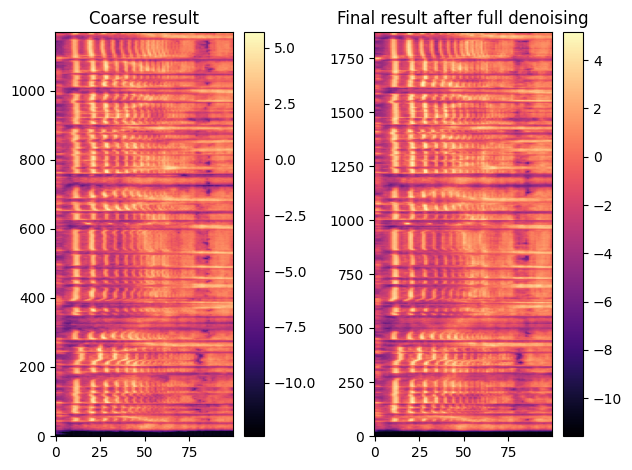

bpm:113
initial audio:


stretched with librosa:


stretched audio:


In [7]:


# First stage - generate trajectory up to step intermediate_step
ref_audio_preprocessed, ref_text_preprocessed = preprocess_ref_audio_text(ref_audio, ref_text) 

first_audio, sr, mel_spec, first_trajectory = infer_single_process(
    ref_audio_preprocessed, ref_text_preprocessed, gen_text, ema_model, vocoder, 
    mel_spec_type=mel_spec_type, 
    nfe_step=total_steps,
    speed=speed,
    end_step=total_steps,
    seed=1234,
    cfg_strength=2.0,
)

# Get intermediate state and remove noise according to schedule
noise_scale = get_noise_schedule(intermediate_step, total_steps)
intermediate_state = first_trajectory[-1]

# Stretch intermediate state
orig_len = intermediate_state.shape[1]
new_len = int(orig_len * stretch_factor)
stretched_state = F.interpolate(
    intermediate_state.permute(0, 2, 1), 
    size=new_len, 
    mode='linear', 
    align_corners=False
).permute(0, 2, 1).to(device)

# Add new noise scaled to the same amount we removed
new_noise = torch.randn(
    stretched_state.shape[0], 
    new_len,
    stretched_state.shape[2], 
    device=device, 
    dtype=stretched_state.dtype,
) 
stretched_state_with_noise = stretched_state * (1 - noise_scale) + new_noise * noise_scale


# Stretch reference
'''
# Тест растяжения рефа. Не работает
target_sr = 24000
audio, sr = librosa.load(ref_audio_preprocessed)
audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
speed_changed = librosa.effects.time_stretch(
    y=audio_resampled.astype(np.float32),
    rate=1/stretch_factor
)
sf.write('ref.mp3', speed_changed, sr)
ref_audio_preprocessed = 'ref.mp3'
stretch_factor = 1.0
'''

# First mel spectrogram (coarse)
plt.subplot(1, 2, 1)
plt.imshow(mel_spec.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()
plt.title('Coarse result')


# Continue flow from step N+1 with stretched state
audio, sr, mel_spec, final_trajectory = infer_single_process(
    ref_audio_preprocessed, ref_text_preprocessed, gen_text, ema_model_fine, vocoder, 
    mel_spec_type=mel_spec_type, 
    nfe_step=total_steps,
    speed=speed / 2, 
    stretch_factor=stretch_factor,
    start_step=intermediate_step,
    initial_state=stretched_state_with_noise,
    cfg_strength=2.0,
)

 
# Second mel spectrogram (fine)
plt.subplot(1, 2, 2)
plt.imshow(mel_spec.T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar()
plt.title('Final result after full denoising')

plt.tight_layout()
plt.show()

print(f"bpm:{ref_bpm}")


# Save and play final audio
print("initial audio:")
sf.write("stretch_test_nostretch.mp3", first_audio, sr)
display(Audio("stretch_test_nostretch.mp3"))

speed_changed = librosa.effects.time_stretch(
    y=first_audio.astype(np.float32),
    rate=1/stretch_factor
)
print("stretched with librosa:")
sf.write("stretch_test_librosa.mp3", speed_changed, sr)
display(Audio("stretch_test_librosa.mp3"))

print("stretched audio:")
sf.write("stretch_test.mp3", audio, sr)
display(Audio("stretch_test.mp3"))
